In [ ]:
%matplotlib  inline

# Train a CNN classifier and compare Normalized Margin

We are going to train a basic CNN model with or without batch normalization. Margins (normalized) will be shown along the training. 

In [1]:
# -*- coding: utf-8 -*-
__author__ = 'huangyf'

In [2]:
import os
import sys
import pickle
import torch
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import basic_cnn
#from collections import OrderedDict #if import basic_cnn, this line can be dropped
from utils import AverageMeter, accuracy, get_margin

#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

use_gpu = torch.cuda.is_available()

In [3]:
class CNN(nn.Module):
    def __init__(self, channels, output_size, with_bn=True):
        super(CNN, self).__init__()
        self.with_bn = with_bn
        self.features = self._make_layers(channels)
        self.classifier = nn.Linear(channels, output_size)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, channels):
        layers = []
        in_channels = 3
        for i in range(5):
            if i == 0:
                if self.with_bn:
                    layers += [('conv%d' % i, nn.Conv2d(in_channels, channels, 3, 2, 1)),
                               ('bn%d' % i, nn.BatchNorm2d(channels)),
                               ('relu%d' % i, nn.ReLU(inplace=True))]
                else:
                    layers += [('conv%d' % i, nn.Conv2d(in_channels, channels, 3, 2, 1)),
                               ('relu%d' % i, nn.ReLU(inplace=True))]
            else:
                if self.with_bn:
                    layers += [('conv%d' % i, nn.Conv2d(channels, channels, 3, 2, 1)),
                               ('bn%d' % i, nn.BatchNorm2d(channels)),
                               ('relu%d' % i, nn.ReLU(inplace=True))]
                else:
                    layers += [('conv%d' % i, nn.Conv2d(channels, channels, 3, 2, 1)),
                               ('relu%d' % i, nn.ReLU(inplace=True))]
        return nn.Sequential(OrderedDict(layers))

In [4]:
def train_model(model, criterion, optimizer, log_saver, num_epochs=100):
    since = time.time()
    steps = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        margin = []

        for phase in ['train', 'test']:

            loss_meter = AverageMeter()
            acc_meter = AverageMeter()

            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            for i, data in enumerate(loaders[phase]):
                inputs, labels_original = data
                labels = torch.FloatTensor(labels_original.size(0),10).zero_()
                labels.scatter_(1, labels_original.view(-1,1), 1)
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                    labels_original=labels_original.cuda()
                inputs = Variable(inputs)
                labels = Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    steps += 1
                    margin = np.append(margin, get_margin(outputs, labels_original))

                loss_meter.update(loss.data.item(), outputs.size(0))
                acc_meter.update(accuracy(outputs.data, labels_original.data)[-1].item(), outputs.size(0))

            epoch_loss = loss_meter.avg
            epoch_error = 1 - acc_meter.avg / 100

            if phase == 'train':

                log_saver['train_loss'].append(epoch_loss)
                log_saver['train_error'].append(epoch_error)
                log_saver['margin'].append(min(margin))
                ww = 1
                for i in range(6):
                    if i <= 4:
                        size = eval('model.features.conv%d.weight.size()' % i)
                        # here to compute the F norm between each CNN layer
                        #w_norm = eval('model.features.conv%d.weight.view(size[0],-1).pow(2).sum(1).mean().data.item()' % i)
                        #model.features.conv0.weight*model.features.bn0.weight[:,None,None,None]/(model.features.bn0.running_var.sqrt()[:,None,None,None]+1e-5)
                        scaled_w = eval('model.features.conv%d.weight*model.features.bn%d.weight[:,None,None,None]/(model.features.bn%d.running_var.sqrt()[:,None,None,None]+1e-5)' % (i,i,i))
                        w_norm = scaled_w.view(size[0],-1).pow(2).sum().sqrt().data.item()

                        log_saver['w%d' % i].append(w_norm)
                    else:
                        w_norm = model.classifier.weight.norm(2).data.item()
                        log_saver['w_fc'].append(w_norm)
                    ww *= w_norm
                log_saver['normalised_margin'].append(log_saver['margin'][-1] / ww)

            elif phase == 'test':

                log_saver['test_loss'].append(epoch_loss)
                log_saver['test_error'].append(epoch_error)

            print('{} Loss: {:.4f} Error: {:.4f}'.format(
                phase, epoch_loss, epoch_error), end=' ' if phase == 'train' else '\n')
            if phase == 'train':
                print('w4_norm: {:.4f} Margin: {:.4f} Norm_margin: {:.4f}'.format(log_saver['w4'][-1],
                                                                                  log_saver['margin'][-1],
                                                                                  log_saver['normalised_margin'][-1]))

        if epoch % 30 == 0 or epoch == num_epochs - 1:
            print('Saving..')
            state = {
                'net': model,
                'epoch': epoch,
                'log': log_saver
            }

            if not os.path.isdir('checkpoint_CNN'):
                os.mkdir('checkpoint_CNN')
            torch.save(state, './checkpoint_CNN/ckpt_epoch_{}.t7'.format(epoch))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model, log_saver


In [5]:
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])

In [6]:
training_dataset = datasets.CIFAR10(root, train=True, transform=img_transforms, download=True)
training_loader = DataLoader(training_dataset, BATCH_SIZE, shuffle=True, pin_memory=True)

testing_dataset = datasets.CIFAR10(root, train=False, transform=img_transforms)
testing_loader = DataLoader(testing_dataset, BATCH_SIZE, shuffle=False, pin_memory=True)

loaders = {'train': training_loader, 'test': testing_loader}

Files already downloaded and verified


# Train CNN with Batch-Normalization and Square Loss

In [7]:
log = {'num_params': [],
       'train_loss': [],
       'train_error': [],
       'test_loss': [],
       'test_error': [],
       'w0': [], 'w1': [], 'w2': [],
       'w3': [], 'w4': [], 'w_fc': [],
       'margin': [], 'normalised_margin': []}

# %% run the model
num_epochs = 100
channels = 100
# here use with_bn to control batch normalisation
model = basic_cnn.CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
log['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

print('number-of-parameters:',log['num_params'])

for name, param in model.named_parameters(): #for name, param in model.state_dict().items():
    if param.requires_grad:
        print('Gradient updated parameter_name:',name)
        
for name1, param1 in model.state_dict().items():
    print('All parameter_name:',name1)

number-of-parameters: [365210]
Gradient updated parameter_name: features.conv0.weight
Gradient updated parameter_name: features.conv0.bias
Gradient updated parameter_name: features.bn0.weight
Gradient updated parameter_name: features.bn0.bias
Gradient updated parameter_name: features.conv1.weight
Gradient updated parameter_name: features.conv1.bias
Gradient updated parameter_name: features.bn1.weight
Gradient updated parameter_name: features.bn1.bias
Gradient updated parameter_name: features.conv2.weight
Gradient updated parameter_name: features.conv2.bias
Gradient updated parameter_name: features.bn2.weight
Gradient updated parameter_name: features.bn2.bias
Gradient updated parameter_name: features.conv3.weight
Gradient updated parameter_name: features.conv3.bias
Gradient updated parameter_name: features.bn3.weight
Gradient updated parameter_name: features.bn3.bias
Gradient updated parameter_name: features.conv4.weight
Gradient updated parameter_name: features.conv4.bias
Gradient upda

In [8]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model, log = train_model(model, criterion, optimizer, log, num_epochs=num_epochs)


Epoch 1/100
----------
train Loss: 0.0960 Error: 0.7661 w4_norm: 17.4994 Margin: -1.7247 Norm_margin: -0.0000
test Loss: 0.0842 Error: 0.7033
Saving..
Epoch 2/100
----------
train Loss: 0.0819 Error: 0.6652 w4_norm: 16.0617 Margin: -1.0223 Norm_margin: -0.0000
test Loss: 0.0797 Error: 0.6457
Epoch 3/100
----------
train Loss: 0.0787 Error: 0.6249 w4_norm: 15.6241 Margin: -0.9543 Norm_margin: -0.0000
test Loss: 0.0773 Error: 0.6119
Epoch 4/100
----------
train Loss: 0.0765 Error: 0.5977 w4_norm: 15.4667 Margin: -0.8497 Norm_margin: -0.0000
test Loss: 0.0755 Error: 0.5908
Epoch 5/100
----------
train Loss: 0.0748 Error: 0.5783 w4_norm: 15.5761 Margin: -0.9026 Norm_margin: -0.0000
test Loss: 0.0739 Error: 0.5713
Epoch 6/100
----------
train Loss: 0.0733 Error: 0.5629 w4_norm: 15.5629 Margin: -1.0146 Norm_margin: -0.0000
test Loss: 0.0727 Error: 0.5603
Epoch 7/100
----------
train Loss: 0.0721 Error: 0.5495 w4_norm: 15.4535 Margin: -0.9084 Norm_margin: -0.0000
test Loss: 0.0716 Error: 0.55

train Loss: 0.0446 Error: 0.2802 w4_norm: 17.7708 Margin: -1.3611 Norm_margin: -0.0000
test Loss: 0.0530 Error: 0.3665
Epoch 63/100
----------
train Loss: 0.0442 Error: 0.2778 w4_norm: 17.7745 Margin: -1.4707 Norm_margin: -0.0000
test Loss: 0.0532 Error: 0.3692
Epoch 64/100
----------
train Loss: 0.0440 Error: 0.2768 w4_norm: 17.7882 Margin: -1.4061 Norm_margin: -0.0000
test Loss: 0.0530 Error: 0.3673
Epoch 65/100
----------
train Loss: 0.0436 Error: 0.2728 w4_norm: 17.8305 Margin: -1.3580 Norm_margin: -0.0000
test Loss: 0.0528 Error: 0.3681
Epoch 66/100
----------
train Loss: 0.0434 Error: 0.2705 w4_norm: 17.9126 Margin: -1.3659 Norm_margin: -0.0000
test Loss: 0.0527 Error: 0.3634
Epoch 67/100
----------
train Loss: 0.0431 Error: 0.2696 w4_norm: 17.9160 Margin: -1.3635 Norm_margin: -0.0000
test Loss: 0.0528 Error: 0.3629
Epoch 68/100
----------
train Loss: 0.0427 Error: 0.2640 w4_norm: 18.1545 Margin: -1.4274 Norm_margin: -0.0000
test Loss: 0.0527 Error: 0.3639
Epoch 69/100
----------

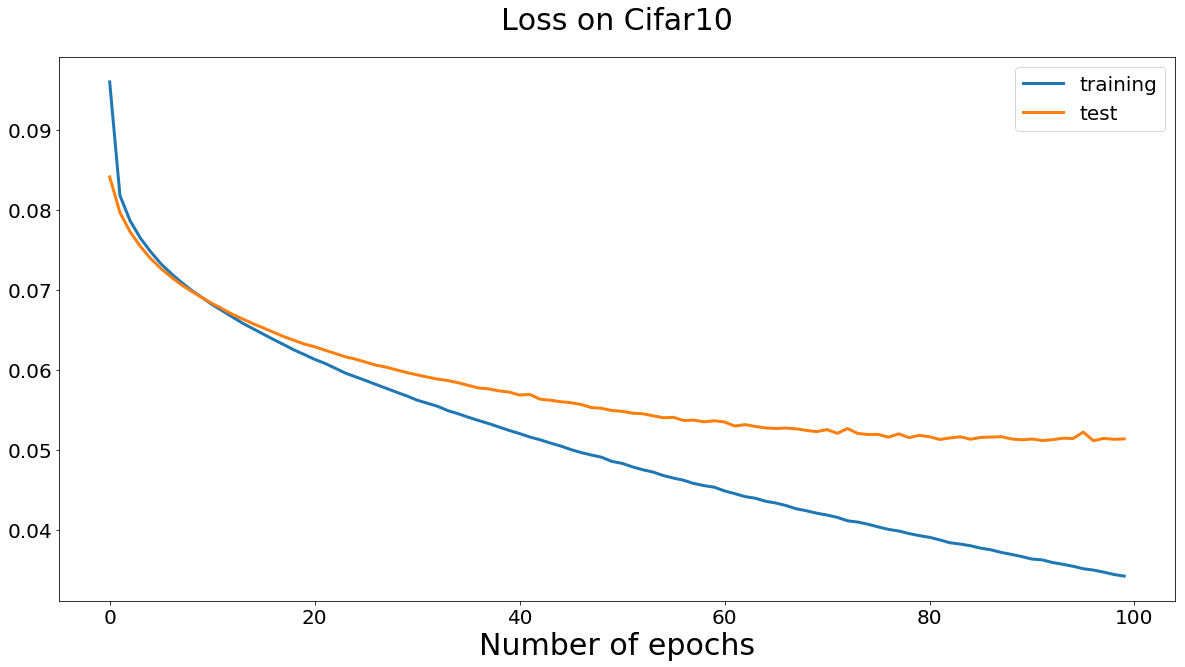

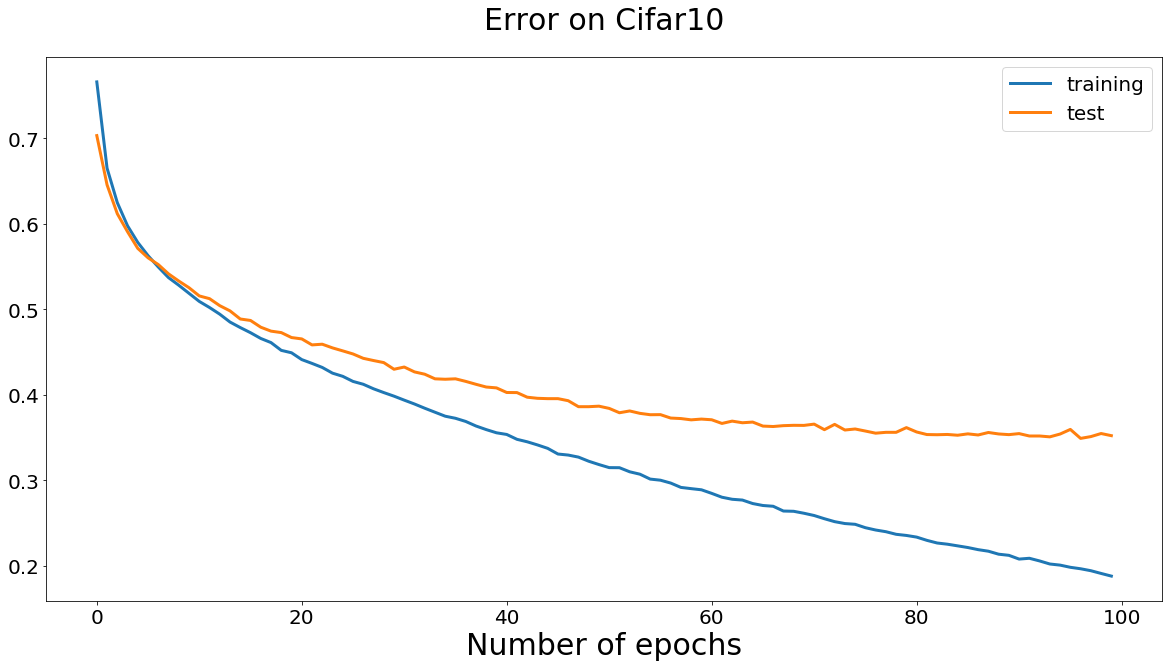

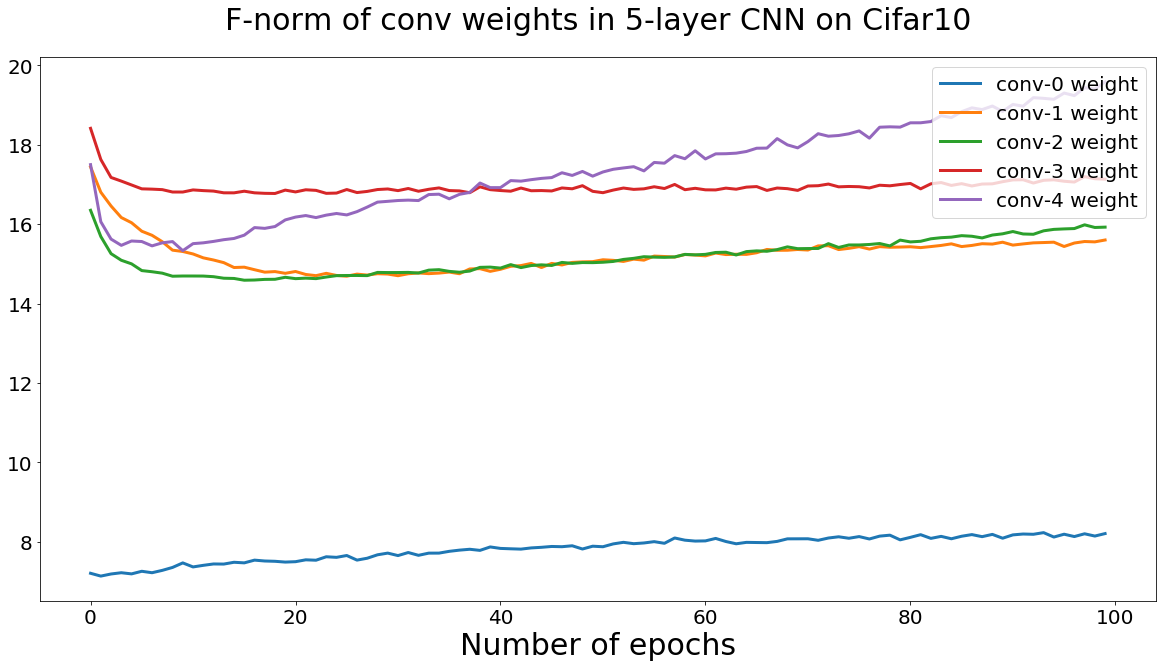

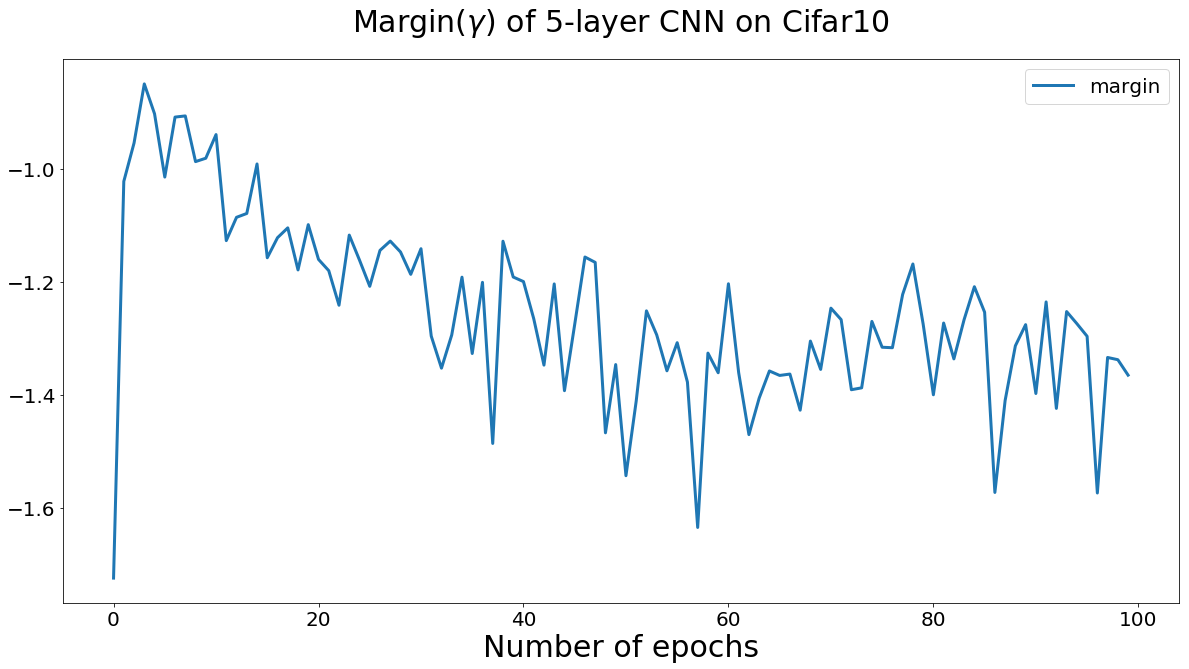

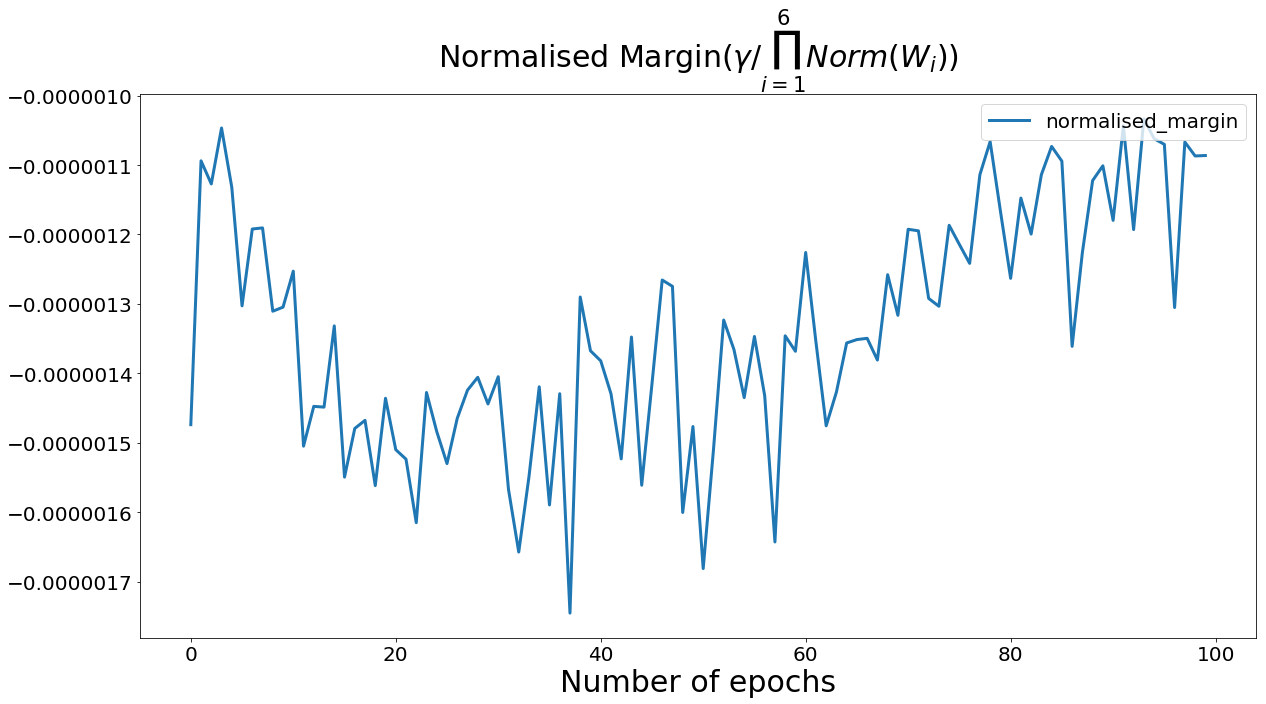

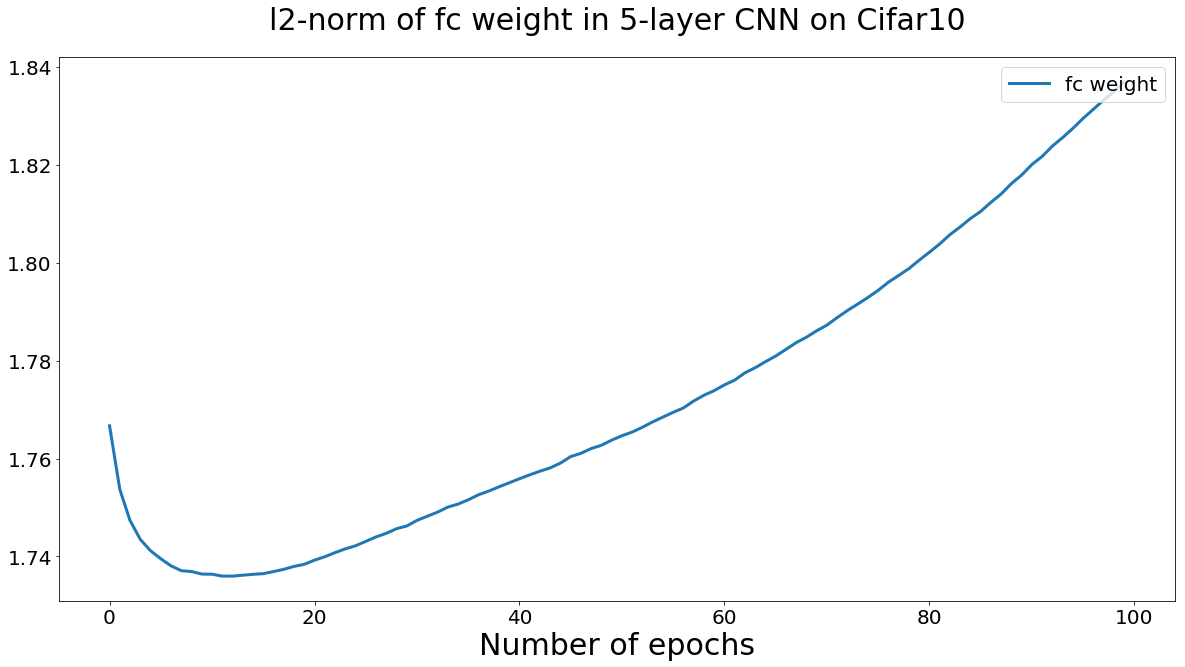

In [10]:
# %% show the results
def plot():
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')
    fig3, ax3 = get_fig(3, 'F-norm of conv weights in 5-layer CNN on Cifar10')
    fig4, ax4 = get_fig(4, 'Margin($\gamma$) of 5-layer CNN on Cifar10')
    fig5, ax5 = get_fig(5, 'Normalised Margin($\gamma/\prod_{i=1}^{6}Norm(W_{i})$)')
    fig6, ax6 = get_fig(6, 'l2-norm of fc weight in 5-layer CNN on Cifar10')

    ax1.plot(log['train_loss'], linewidth=3, label='training')
    ax1.plot(log['test_loss'], linewidth=3, label='test')
    ax2.plot(log['train_error'], linewidth=3, label='training')
    ax2.plot(log['test_error'], linewidth=3, label='test')

    for i in range(5):
        ax3.plot(log['w%d' % i], linewidth=3, label='conv-%d weight' % i)

    ax4.plot(log['margin'], linewidth=3, label='margin')
    ax5.plot(log['normalised_margin'], linewidth=3, label='normalised_margin')
    ax6.plot(log['w_fc'], linewidth=3, label='fc weight')

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)

    result_dir = './results_bn/'
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'loss%d.png' % channels)
    fig2.savefig(result_dir + 'error%d.png' % channels)
    fig3.savefig(result_dir + 'conv_weight%d.png' % channels)
    fig4.savefig(result_dir + 'margin%d.png' % channels)
    fig5.savefig(result_dir + 'n_margin%d.png' % channels)
    fig6.savefig(result_dir + 'fc_weight%d.png' % channels)


plot()
plt.show()


In [11]:
# Train another 100 epochs more...
model, log = train_model(model, criterion, optimizer, log, num_epochs=num_epochs)

Epoch 1/100
----------
train Loss: 0.0340 Error: 0.1880 w4_norm: 19.2682 Margin: -1.3821 Norm_margin: -0.0000
test Loss: 0.0513 Error: 0.3545
Saving..
Epoch 2/100
----------
train Loss: 0.0337 Error: 0.1846 w4_norm: 19.4779 Margin: -1.2254 Norm_margin: -0.0000
test Loss: 0.0517 Error: 0.3609
Epoch 3/100
----------
train Loss: 0.0336 Error: 0.1837 w4_norm: 19.6547 Margin: -1.2994 Norm_margin: -0.0000
test Loss: 0.0514 Error: 0.3527
Epoch 4/100
----------
train Loss: 0.0333 Error: 0.1830 w4_norm: 19.5486 Margin: -1.3654 Norm_margin: -0.0000
test Loss: 0.0516 Error: 0.3564
Epoch 5/100
----------
train Loss: 0.0331 Error: 0.1817 w4_norm: 19.5692 Margin: -1.2219 Norm_margin: -0.0000
test Loss: 0.0514 Error: 0.3512
Epoch 6/100
----------
train Loss: 0.0328 Error: 0.1772 w4_norm: 19.6557 Margin: -1.3953 Norm_margin: -0.0000
test Loss: 0.0517 Error: 0.3557
Epoch 7/100
----------
train Loss: 0.0326 Error: 0.1759 w4_norm: 19.7168 Margin: -1.1907 Norm_margin: -0.0000
test Loss: 0.0521 Error: 0.35

test Loss: 0.0549 Error: 0.3691
Epoch 59/100
----------
train Loss: 0.0224 Error: 0.0898 w4_norm: 21.6593 Margin: -1.2239 Norm_margin: -0.0000
test Loss: 0.0548 Error: 0.3680
Epoch 60/100
----------
train Loss: 0.0222 Error: 0.0874 w4_norm: 21.6935 Margin: -1.1552 Norm_margin: -0.0000
test Loss: 0.0549 Error: 0.3671
Epoch 61/100
----------
train Loss: 0.0221 Error: 0.0864 w4_norm: 21.9249 Margin: -1.0838 Norm_margin: -0.0000
test Loss: 0.0553 Error: 0.3724
Saving..
Epoch 62/100
----------
train Loss: 0.0219 Error: 0.0870 w4_norm: 21.7976 Margin: -1.2064 Norm_margin: -0.0000
test Loss: 0.0559 Error: 0.3712
Epoch 63/100
----------
train Loss: 0.0217 Error: 0.0833 w4_norm: 22.0546 Margin: -1.1635 Norm_margin: -0.0000
test Loss: 0.0558 Error: 0.3728
Epoch 64/100
----------
train Loss: 0.0215 Error: 0.0829 w4_norm: 21.7163 Margin: -1.1323 Norm_margin: -0.0000
test Loss: 0.0551 Error: 0.3704
Epoch 65/100
----------
train Loss: 0.0213 Error: 0.0808 w4_norm: 21.8561 Margin: -1.1811 Norm_margin

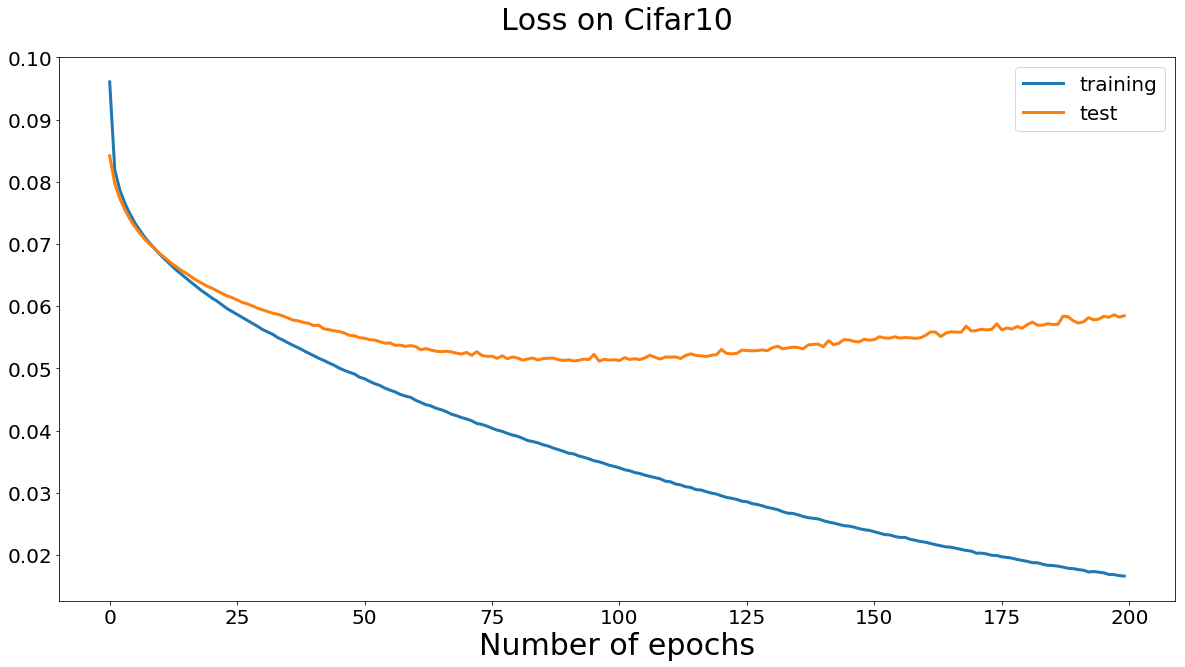

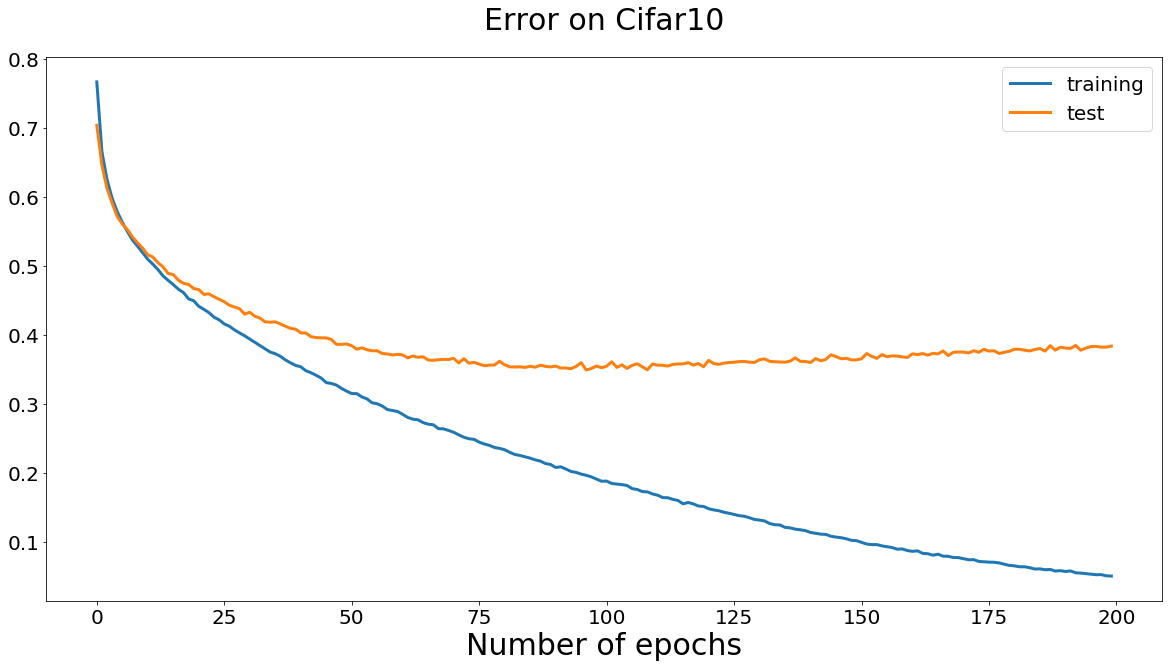

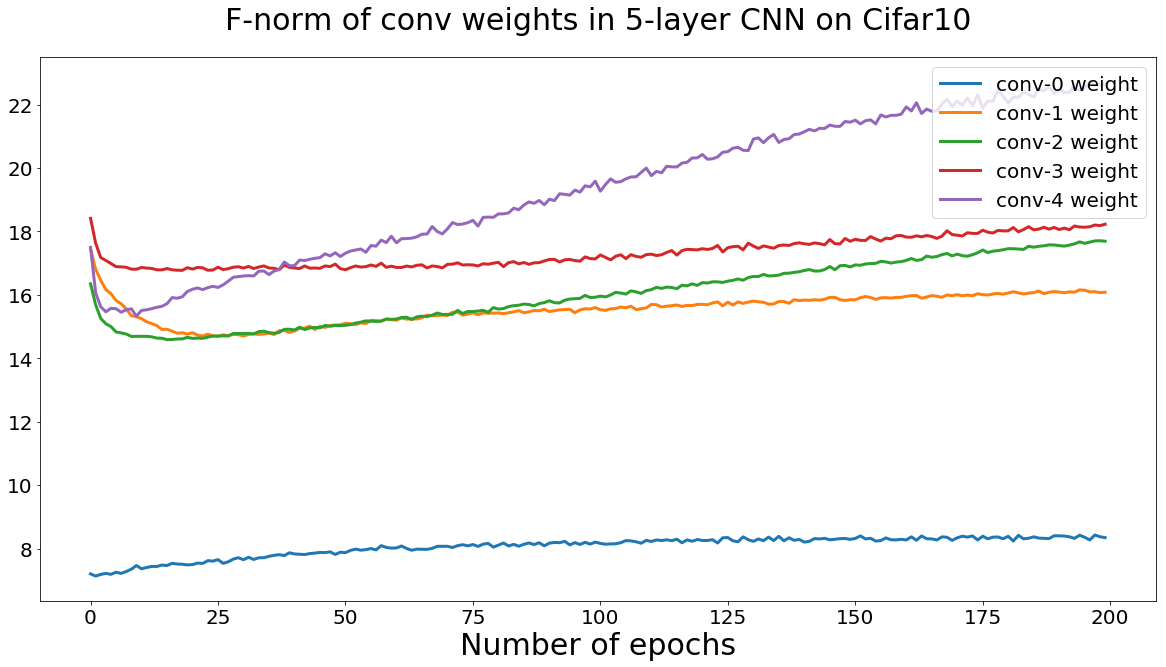

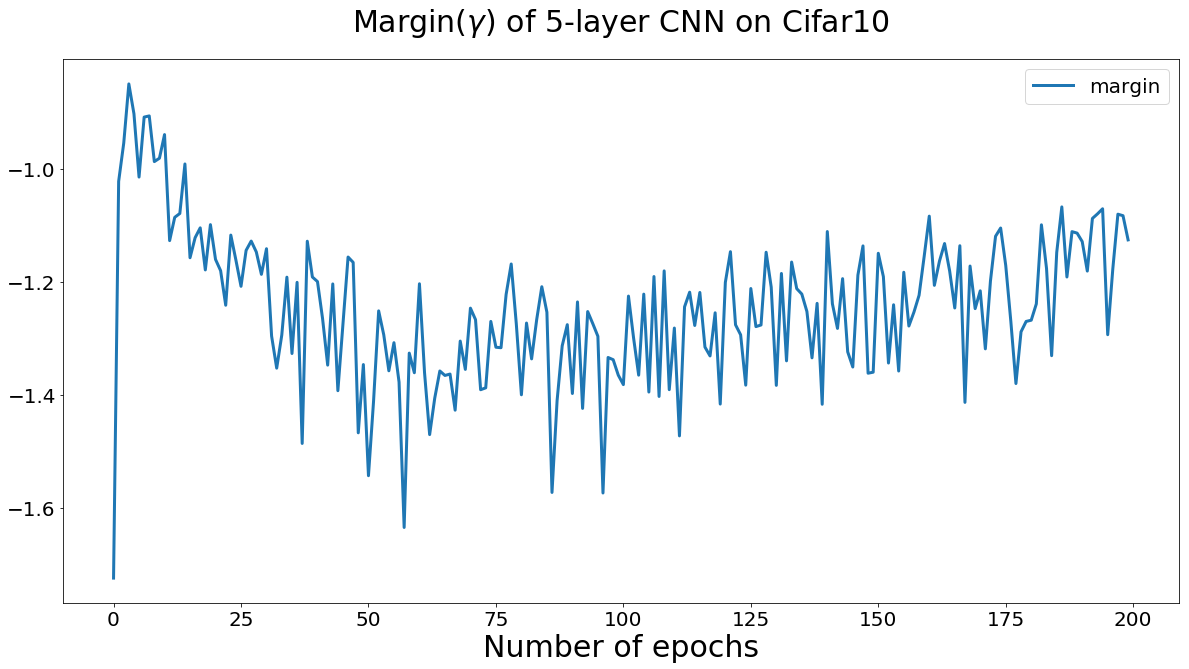

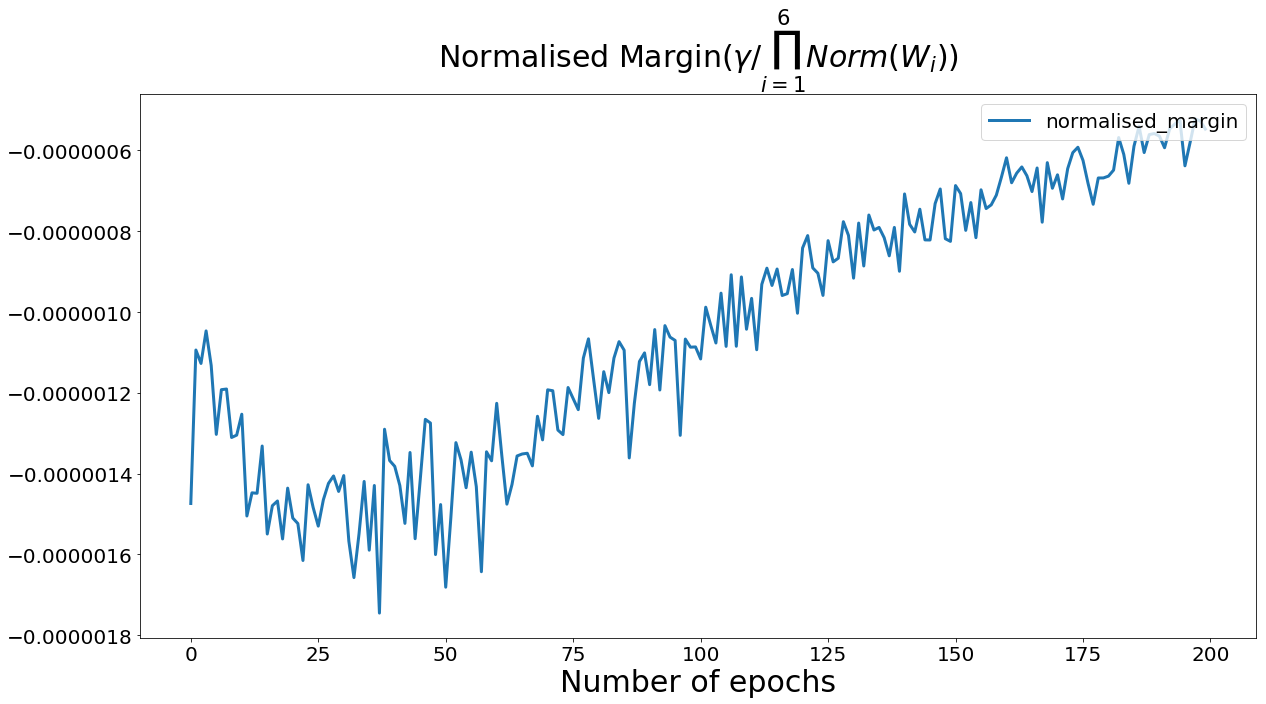

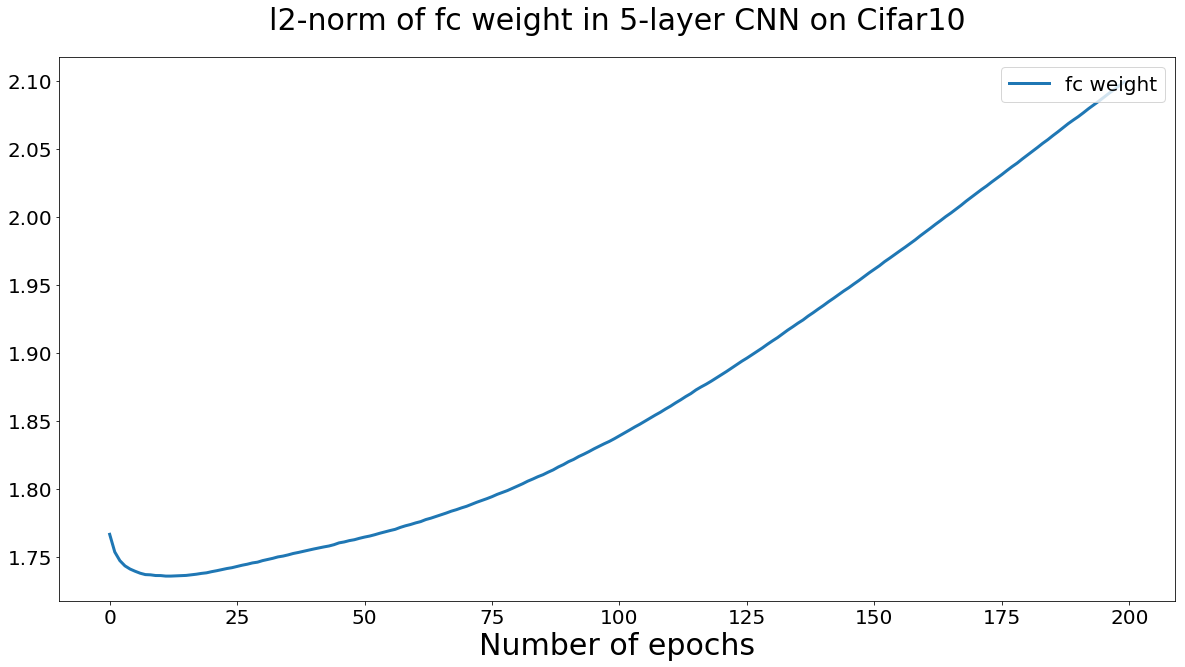

In [13]:
# %% show the results
def plot():
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')
    fig3, ax3 = get_fig(3, 'F-norm of conv weights in 5-layer CNN on Cifar10')
    fig4, ax4 = get_fig(4, 'Margin($\gamma$) of 5-layer CNN on Cifar10')
    fig5, ax5 = get_fig(5, 'Normalised Margin($\gamma/\prod_{i=1}^{6}Norm(W_{i})$)')
    fig6, ax6 = get_fig(6, 'l2-norm of fc weight in 5-layer CNN on Cifar10')

    ax1.plot(log['train_loss'], linewidth=3, label='training')
    ax1.plot(log['test_loss'], linewidth=3, label='test')
    ax2.plot(log['train_error'], linewidth=3, label='training')
    ax2.plot(log['test_error'], linewidth=3, label='test')

    for i in range(5):
        ax3.plot(log['w%d' % i], linewidth=3, label='conv-%d weight' % i)

    ax4.plot(log['margin'], linewidth=3, label='margin')
    ax5.plot(log['normalised_margin'], linewidth=3, label='normalised_margin')
    ax6.plot(log['w_fc'], linewidth=3, label='fc weight')

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)

    result_dir = './results_bn/'
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'loss%d.png' % channels)
    fig2.savefig(result_dir + 'error%d.png' % channels)
    fig3.savefig(result_dir + 'conv_weight%d.png' % channels)
    fig4.savefig(result_dir + 'margin%d.png' % channels)
    fig5.savefig(result_dir + 'n_margin%d.png' % channels)
    fig6.savefig(result_dir + 'fc_weight%d.png' % channels)


plot()
plt.show()


# Train CNN with Batch-Normalization and Cross-Entropy Loss

In [15]:
log1 = {'num_params': [],
       'train_loss': [],
       'train_error': [],
       'test_loss': [],
       'test_error': [],
       'w0': [], 'w1': [], 'w2': [],
       'w3': [], 'w4': [], 'w_fc': [],
       'margin': [], 'normalised_margin': []}

In [16]:
# %% run the model
num_epochs = 100
channels = 100
# here use with_bn to control batch normalisation
model1 = basic_cnn.CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
log['num_params'].append(number_params)

if use_gpu:
    model1 = model1.cuda()


In [17]:
print('number-of-parameters:',log['num_params'])

number-of-parameters: [365210, 365210]


In [18]:
for name, param in model1.named_parameters(): #for name, param in model.state_dict().items():
    if param.requires_grad:
        print('parameter_name:',name)

parameter_name: features.conv0.weight
parameter_name: features.conv0.bias
parameter_name: features.bn0.weight
parameter_name: features.bn0.bias
parameter_name: features.conv1.weight
parameter_name: features.conv1.bias
parameter_name: features.bn1.weight
parameter_name: features.bn1.bias
parameter_name: features.conv2.weight
parameter_name: features.conv2.bias
parameter_name: features.bn2.weight
parameter_name: features.bn2.bias
parameter_name: features.conv3.weight
parameter_name: features.conv3.bias
parameter_name: features.bn3.weight
parameter_name: features.bn3.bias
parameter_name: features.conv4.weight
parameter_name: features.conv4.bias
parameter_name: features.bn4.weight
parameter_name: features.bn4.bias
parameter_name: classifier.weight
parameter_name: classifier.bias


In [19]:
for name1, param1 in model1.state_dict().items():
    print('parameter_name:',name1)

parameter_name: features.conv0.weight
parameter_name: features.conv0.bias
parameter_name: features.bn0.weight
parameter_name: features.bn0.bias
parameter_name: features.bn0.running_mean
parameter_name: features.bn0.running_var
parameter_name: features.conv1.weight
parameter_name: features.conv1.bias
parameter_name: features.bn1.weight
parameter_name: features.bn1.bias
parameter_name: features.bn1.running_mean
parameter_name: features.bn1.running_var
parameter_name: features.conv2.weight
parameter_name: features.conv2.bias
parameter_name: features.bn2.weight
parameter_name: features.bn2.bias
parameter_name: features.bn2.running_mean
parameter_name: features.bn2.running_var
parameter_name: features.conv3.weight
parameter_name: features.conv3.bias
parameter_name: features.bn3.weight
parameter_name: features.bn3.bias
parameter_name: features.bn3.running_mean
parameter_name: features.bn3.running_var
parameter_name: features.conv4.weight
parameter_name: features.conv4.bias
parameter_name: fe

In [20]:
print('conv0.weight.size():\n', model1.features.conv0.weight.size())
print( model1.features.conv0.weight*model1.features.bn0.weight[:,None,None,None]/(model1.features.bn0.running_var.sqrt()[:,None,None,None]+1e-5))
print('model.features.bn0.weight:\n',model1.features.bn0.weight.size(),'\n model.features.bn0.running_var_sqrt:\n',model1.features.bn0.running_var.sqrt()+1e-5)

conv0.weight.size():
 torch.Size([100, 3, 3, 3])
tensor([[[[-1.0671e-01,  1.1938e-01, -9.7034e-02],
          [ 6.3999e-02, -3.9453e-02,  4.0725e-02],
          [-7.7776e-02, -9.1206e-02,  1.7469e-02]],

         [[ 5.1970e-02, -1.0655e-01,  6.5871e-02],
          [-2.7295e-02, -1.2322e-01,  1.9782e-02],
          [ 6.2394e-02, -6.5818e-02,  2.6974e-02]],

         [[-6.1744e-02,  1.1493e-01,  9.1844e-02],
          [ 7.1598e-02, -1.2252e-01, -6.0673e-02],
          [-8.7936e-02,  4.1213e-02, -7.9672e-02]]],


        [[[ 6.1674e-02, -1.0457e-01, -1.2808e-01],
          [ 1.2449e-01,  9.7979e-02, -1.2294e-01],
          [-1.0572e-01, -2.6324e-02, -2.7273e-02]],

         [[-1.3647e-01, -4.2924e-02,  8.8681e-02],
          [-2.9493e-02,  5.8249e-02, -1.0913e-01],
          [ 9.5850e-02,  1.4452e-01, -1.1791e-01]],

         [[-3.2666e-02,  9.5035e-02,  4.0139e-02],
          [ 7.2108e-02, -1.4005e-01, -7.0624e-02],
          [ 2.1692e-02,  1.0294e-01,  1.0647e-02]]],


        [[[-2.764

In [21]:
print('\gamma/(\sqrt{Var_run}+\eps):\n',
      model1.features.bn0.weight/(model1.features.bn0.running_var.sqrt()+1e-5))

\gamma/(\sqrt{Var_run}+\eps):
 tensor([ 0.6435,  0.9358,  0.0512,  0.8612,  0.0397,  0.1923,  0.3951,
         0.6262,  0.1722,  0.8814,  0.9978,  0.4295,  0.7415,  0.2580,
         0.6837,  0.9467,  0.6798,  0.3515,  0.3114,  0.2996,  0.0337,
         0.9149,  0.9287,  0.0659,  0.1083,  0.7687,  0.8562,  0.2074,
         0.3132,  0.6280,  0.4775,  0.4617,  0.0789,  0.7517,  0.9424,
         0.4422,  0.8375,  0.5812,  0.6980,  0.4711,  0.1182,  0.7074,
         0.7822,  0.4883,  0.4787,  0.3868,  0.1368,  0.0759,  0.7518,
         0.4725,  0.6576,  0.7474,  0.2395,  0.2207,  0.1076,  0.8065,
         0.0569,  0.0011,  0.4953,  0.0842,  0.2476,  0.0028,  0.9447,
         0.6003,  0.5944,  0.4706,  0.2801,  0.5033,  0.4453,  0.6655,
         0.4181,  0.5380,  0.1401,  0.0155,  0.8335,  0.3929,  0.2361,
         0.3857,  0.6768,  0.4595,  0.1373,  0.3194,  0.2653,  0.8316,
         0.6588,  0.2874,  0.5110,  0.6019,  0.9713,  0.2251,  0.8665,
         0.7202,  0.4071,  0.4278,  0.6721,  0

In [22]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSECriterion()
optimizer = optim.SGD(model1.parameters(), lr=lr, weight_decay=weight_decay)

model1, log1 = train_model(model1, criterion, optimizer, log1, num_epochs=num_epochs)


Epoch 1/100
----------


RuntimeError: Expected object of type torch.cuda.LongTensor but found type torch.cuda.FloatTensor for argument #2 'target'

# (Yuan YAO): 

we need to compute the weight (gamma) and standard deviation 
(features.bn.running_var.sqrt()? epsilon here?) for batch normalization layers.

In [ ]:
# %% show the results
def plot():
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')
    fig3, ax3 = get_fig(3, 'F-norm of conv weights in 5-layer CNN on Cifar10')
    fig4, ax4 = get_fig(4, 'Margin($\gamma$) of 5-layer CNN on Cifar10')
    fig5, ax5 = get_fig(5, 'Normalised Margin($\gamma/\prod_{i=1}^{6}Norm(W_{i})$)')
    fig6, ax6 = get_fig(6, 'l2-norm of fc weight in 5-layer CNN on Cifar10')

    ax1.plot(log1['train_loss'], linewidth=3, label='training')
    ax1.plot(log1['test_loss'], linewidth=3, label='test')
    ax2.plot(log1['train_error'], linewidth=3, label='training')
    ax2.plot(log1['test_error'], linewidth=3, label='test')

    for i in range(5):
        ax3.plot(log1['w%d' % i], linewidth=3, label='conv-%d weight' % i)

    ax4.plot(log1['margin'], linewidth=3, label='margin')
    ax5.semilogy(log1['normalised_margin'], linewidth=3, label='normalised_margin')
    ax6.plot(log1['w_fc'], linewidth=3, label='fc weight')

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)

    result_dir = './results_bn/'
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'loss%d.png' % channels)
    fig2.savefig(result_dir + 'error%d.png' % channels)
    fig3.savefig(result_dir + 'conv_weight%d.png' % channels)
    fig4.savefig(result_dir + 'margin%d.png' % channels)
    fig5.savefig(result_dir + 'n_margin%d.png' % channels)
    fig6.savefig(result_dir + 'fc_weight%d.png' % channels)


plot()
plt.show()


## Train Without batch normalization

In [ ]:
def train_model(model, criterion, optimizer, log_saver, num_epochs=100):
    since = time.time()
    steps = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        margin = []

        for phase in ['train', 'test']:

            loss_meter = AverageMeter()
            acc_meter = AverageMeter()

            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            for i, data in enumerate(loaders[phase]):
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                inputs = Variable(inputs)
                labels = Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    steps += 1
                    margin = np.append(margin, get_margin(outputs, labels))

                loss_meter.update(loss.data.item(), outputs.size(0))
                acc_meter.update(accuracy(outputs.data, labels.data)[-1].item(), outputs.size(0))

            epoch_loss = loss_meter.avg
            epoch_error = 1 - acc_meter.avg / 100

            if phase == 'train':

                log_saver['train_loss'].append(epoch_loss)
                log_saver['train_error'].append(epoch_error)
                log_saver['margin'].append(min(margin))
                ww = 1
                for i in range(6):
                    if i <= 4:
                        size = eval('model.features.conv%d.weight.size()' % i)
                        # here to compute the F norm between each CNN layer
                        w_norm = eval('model.features.conv%d.weight.view(size[0],-1).pow(2).sum().sqrt().data.item()' % i)
                        #model.features.conv0.weight*model.features.bn0.weight[:,None,None,None]/(model.features.bn0.running_var.sqrt()[:,None,None,None]+1e-5)
                        #scaled_w = eval('model.features.conv%d.weight*model.features.bn%d.weight[:,None,None,None]/(model.features.bn%d.running_var.sqrt()[:,None,None,None]+1e-5)' % (i,i,i))
                        #w_norm = scaled_w.view(size[0],-1).pow(2).sum().sqrt().data.item()

                        log_saver['w%d' % i].append(w_norm)
                    else:
                        w_norm = model.classifier.weight.norm(2).data.item()
                        log_saver['w_fc'].append(w_norm)
                    ww *= w_norm
                log_saver['normalised_margin'].append(log_saver['margin'][-1] / ww)

            elif phase == 'test':

                log_saver['test_loss'].append(epoch_loss)
                log_saver['test_error'].append(epoch_error)

            print('{} Loss: {:.4f} Error: {:.4f}'.format(
                phase, epoch_loss, epoch_error), end=' ' if phase == 'train' else '\n')
            if phase == 'train':
                print('w4_norm: {:.4f} Margin: {:.4f} Norm_margin: {:.4f}'.format(log_saver['w4'][-1],
                                                                                  log_saver['margin'][-1],
                                                                                  log_saver['normalised_margin'][-1]))

        if epoch % 30 == 0 or epoch == num_epochs - 1:
            print('Saving..')
            state = {
                'net': model,
                'epoch': epoch,
                'log': log_saver
            }

            if not os.path.isdir('checkpoint_CNN'):
                os.mkdir('checkpoint_CNN')
            torch.save(state, './checkpoint_CNN/ckpt_epoch_{}.t7'.format(epoch))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model, log_saver


In [ ]:
# %% run the model without batch normalization
num_epochs = 100
channels = 100

# here use with_bn to control batch normalisation
model0 = basic_cnn.CNN(channels, 10, with_bn=False)

log0 = {'num_params': [],
       'train_loss': [],
       'train_error': [],
       'test_loss': [],
       'test_error': [],
       'w0': [], 'w1': [], 'w2': [],
       'w3': [], 'w4': [], 'w_fc': [],
       'margin': [], 'normalised_margin': []}

number_params = sum(p.numel() for p in model0.parameters() if p.requires_grad)
log0['num_params'].append(number_params)

if use_gpu:
    model0 = model0.cuda()

criterion = nn.CrossEntropyLoss()
optimizer0 = optim.SGD(model0.parameters(), lr=lr, weight_decay=weight_decay)

model0, log0 = train_model(model0, criterion, optimizer0, log0, num_epochs=num_epochs)


In [ ]:
# %% show the results
def plot():
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')
    fig3, ax3 = get_fig(3, 'F-norm of conv weights in 5-layer CNN on Cifar10')
    fig4, ax4 = get_fig(4, 'Margin($\gamma$) of 5-layer CNN on Cifar10')
    fig5, ax5 = get_fig(5, 'Normalised Margin($\gamma/\prod_{i=1}^{6}Norm(W_{i})$)')
    fig6, ax6 = get_fig(6, 'l2-norm of fc weight in 5-layer CNN on Cifar10')

    ax1.plot(log0['train_loss'], linewidth=3, label='training')
    ax1.plot(log0['test_loss'], linewidth=3, label='test')
    ax2.plot(log0['train_error'], linewidth=3, label='training')
    ax2.plot(log0['test_error'], linewidth=3, label='test')

    for i in range(5):
        ax3.plot(log0['w%d' % i], linewidth=3, label='conv-%d weight' % i)

    ax4.plot(log0['margin'], linewidth=3, label='margin')
    ax5.plot(log0['normalised_margin'], linewidth=3, label='normalised_margin')
    ax6.plot(log0['w_fc'], linewidth=3, label='fc weight')

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)

    result_dir = './results_bn/'
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'bn0_loss%d.png' % channels)
    fig2.savefig(result_dir + 'bn0_error%d.png' % channels)
    fig3.savefig(result_dir + 'bn0_conv_weight%d.png' % channels)
    fig4.savefig(result_dir + 'bn0_margin%d.png' % channels)
    fig5.savefig(result_dir + 'bn0_n_margin%d.png' % channels)
    fig6.savefig(result_dir + 'bn0_fc_weight%d.png' % channels)


plot()
plt.show()


In [ ]:
print('Finished.')

So Batch Normalization here significantly speeds up the training, with an improved (normalized) margins. 